In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. We use Expectation Maximization (EM) algorithm to maximize the likelihood of data points given GMM parameters.  

EM algorithm is a coordinate descent optimization of the variational lower bound

$\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max_{q\in Q, \theta\in \Theta}$.

This expectation is maximized in two steps:

> **E_step** : In this step, $\mathcal{L}(\theta, q)$ is maximized over $q$. It is not difficult to see that this is equivalent to minimizing the KullBack_Liebler function:
$$\mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] $$
But the absolute minimum of this function is zero, which is obtained when $q(T) = p(T|X, \theta)$ and **E_step** is solved.

> **M_step** : Having found the optimal value for $q$, we now maximize $\mathcal{L}(\theta, q)$ over $\theta$. This is equivalent to maximixing 
$$\mathbb{E}_{q(T)}\log p(X,T | \theta)$$
over $\theta$, which can be done analytically for GMM. 




For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

In [1]:
import numpy as np
from numpy.linalg import det, solve
import matplotlib.pyplot as plt

Out data set is shown below.

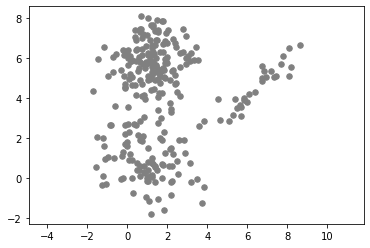

In [2]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

In [3]:
X.shape, pi0.shape, mu0.shape, sigma0.shape

((280, 2), (3,), (3, 2), (3, 2, 2))

Let's implement *E_step* using the function below that calculates the posterior distribution $p(t_i = c| x_i, \theta)$ of the latent variables:

\begin{align*}
\gamma_{ic} =& p(t_i = c| x_i, \theta)\\
=&\frac{p(x_i|t_i=c, \theta)p(t_i=c)}{p(x_i,\theta)}\\
=&\frac{p(x_i|t_i=c, \theta)p(t_i=c)}{\sum_cp(x_i|t_i=c, \theta)p(t_i=c)}
\end{align*}
where,
$$
p(x_i|t_i=c, \theta) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})\right)
$$
is the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$. Also $p(t_i=c) = \pi_c$ is the probability of $x_i$ coming from cluster $c$. 

As computing exponents of large numbers may result in infinity we try to avoid this by dividing numerator and denominator by $e^{\max(y)}$ over all terms in the denominator of $\gamma_{ic}$ above.

In [4]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    gamma = np.zeros((N, C)) # distribution q(T)
    
    # The following loop calculates the argument of 
    # the exponential function as a N x C matrix indexed by (i, c) . 
    
    for c in range(C):
        gamma[:,c] = -0.5*((X-mu[c])@\
            solve(sigma[c], (X-mu[c]).T)).diagonal() 
    
    gamma = np.exp(gamma - gamma.max(axis=1)[:,np.newaxis])
    gamma = gamma * pi / np.sqrt(np.abs(det(sigma)))
    gamma = gamma / gamma.sum(axis=1)[:,np.newaxis]

    return gamma

We now move on to the next step to implement **M_step**, which is to maximize $$\mathbb{E}_{q(T)}\log p(X,T | \theta)$$.

\begin{align*}
\mathbb{E}_{q(T)}\log p(X,T | \theta)=\\
=& \sum_c q(t_i=c)\sum_i \log p(x_i, t_i|\theta)\\
=& \sum_c q(t_i=c)\sum_i (\log p(x_i|t_i, \theta) + \log p(t_i=c))\\
=&\sum_i\sum_c \gamma_{ic}(\log p(x_i|t_i, \theta) + \log \pi_c)
\end{align*}

Taking the derivative with respect to $\mu$, $\sigma$ and $\pi$, we have:
$$\mu_c = \frac{\sum_i\gamma_{ic}x_i}{\sum_i\gamma_{ic}},$$
$$\Sigma_c = \frac{\sum_i \gamma_{ic}(x_i - \mu_c)(x_i - \mu_c)^T}{\sum_i \gamma_{ic}},$$
and
$$\pi_c = \frac{\sum_i \gamma_{ic}}{N}$$
where $\sum_c \pi_{c}=1.$
To find these optimal values we used the following formulas for derivative of matrices:
$$\frac{\partial}{\partial \textbf{s}} (\textbf{x} - \textbf{s})^{T}\textbf{W}(\textbf{x} - \textbf{s}) = -2\textbf{W}(\textbf{x} - \textbf{s}),$$
where $\textbf{W}$ is symmetric.
$$\frac{\partial \textbf{a}^T\textbf{X}^{-1}\textbf{b}}{\partial \textbf{X}} = \textbf{X}^{-T}\textbf{a}\textbf{b}^T\textbf{X}^{-T},$$
$$\frac{\partial \text{det}(\textbf{X})}{\partial \textbf{X}} = \text{det}(\textbf{X})(\textbf{X}^{-1})^T.$$
These are the optimal values for parameteres given the posterior of the latent variable. The following function implements **M_step** . 

In [5]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    sigma = np.zeros((C,d,d))
    pi = gamma.sum(axis=0)/N
    mu = (gamma.T @ X) / gamma.sum(axis=0)[:, np.newaxis]
    
    for c in range(C):
        for i in range(N):
            sigma[c] += gamma[i,c] * ((X[i]- mu[c]).reshape(-1,1) @ \
                  (X[i]- mu[c]).reshape(1,-1))/gamma.sum(axis=0)[c]

    return pi, mu, sigma

In [6]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)

It is gauranteed that EM algorithm pushes the log likelihood to a local max because:
$$\log p(X|\theta^{k+1})\geq \mathcal{L}(\theta^{k+1}, q^{k+1})\geq \mathcal{L}(\theta^{k},q^{k+1})=\log p(X|\theta^{k})$$

Our loss function is the variational lower bound

\begin{align*}
\mathcal{L} =& \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c) - \log q(t_i =c))\\
=& \sum_{i=1}^{N} \sum_{c=1}^{C} \gamma_{ic} (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c) - \log \gamma_{ic})
\end{align*}

In [7]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    
    p = np.zeros((N,C)) # This will contain the log of nomral PDF
    # calculated by the following loop. 
    
    for c in range(C):
        p[:,c] = -0.5*(np.log((2*np.pi)**d*np.abs(np.linalg.det(sigma[c]))) + \
        ((X-mu[c]) @ np.linalg.solve(sigma[c], (X-mu[c]).T)).diagonal())
    
    loss = (gamma * (np.log(pi) + p - np.log(gamma))).sum(axis=1).sum()

    return loss


To test our calculations, we run the following cell:

In [8]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
loss


-1213.9734643060183

Now that we have **E_step**, **M_step** and VLB, we can implement the training loop. We will initialize values of $\pi$, $\mu$ and $\Sigma$ to some random numbers, train until $\mathcal{L}$ stops changing, and return the resulting points. We also know that the EM algorithm converges to local optima. To find a better local optima, we will restart the algorithm multiple times from different (random) starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Initial (random) values of $\pi$ must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite so we use $\Sigma=I$ as initialization.

We might also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to restart the procedure.

In [9]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -20000
    best_pi = None
    best_mu = None
    best_sigma = None
    
    for _ in range(restarts):
        try:
            print('restarting...')
            a = np.random.uniform(0, 1, C)
            pi = a/sum(a)
            sigma = np.zeros((C, d, d))
            for j in range(C):
                sigma[j] = (j+1) * np.eye(d)
            mu = np.random.uniform(0, 3, C * d).reshape(C, d)
           
        
        
            
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)
                l_1 = compute_vlb(X, pi, mu, sigma, gamma)
                pi, mu, sigma = M_step(X, gamma)
                l_2 = compute_vlb(X, pi, mu, sigma, gamma)
                print("The loss is", l_2)
                if (np.absolute((l_2-l_1)/l_1)<rtol):
                    break
            
            
            if l_2 > best_loss:
                best_loss = l_2
                best_pi = pi
                best_mu = mu
                best_sigma = sigma

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [ ]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

restarting...
The loss is -1197.8395610457828
The loss is -1149.4315001747502
The loss is -1127.6126268989533
The loss is -1115.2816445411531
The loss is -1106.9040936472206
The loss is -1100.2592605017292
The loss is -1095.1327084521588
The loss is -1091.1585765886907
The loss is -1087.6007870424146
The loss is -1084.357239480065
The loss is -1081.2905108229252
The loss is -1077.2221761739834
The loss is -1070.3543875085052
The loss is -1064.9261249843198
The loss is -1064.14597829148
restarting...
The loss is -1239.6351448131654
The loss is -1227.4901609144947
The loss is -1199.570329700411
The loss is -1167.312859303619
The loss is -1153.908509554754
The loss is -1145.9621749169673
The loss is -1131.996127850743
The loss is -1110.6839639304785
The loss is -1097.5167311365817
The loss is -1091.1796832139491
The loss is -1085.9379559246
The loss is -1081.1638067717815
The loss is -1076.6145277331161
The loss is -1072.4015973128808
The loss is -1068.911539432639
The loss is -1066.48095

As seen above, EM converges quickly. Let's now look the results in the figure below: 

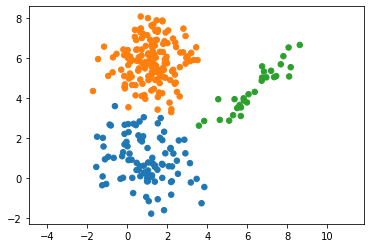

In [129]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
plt.scatter(X[:, 0], X[:, 1], c=colors[labels], s=30)
plt.axis('equal')
plt.show()

The algorithm has high confidence for most points except for some at the border of two clusters:

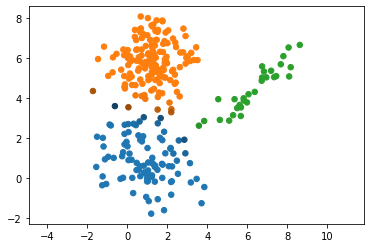

In [131]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
prob = gamma.max(axis=1)[:,np.newaxis]
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
plt.scatter(X[:, 0], X[:, 1], c=colors[labels]*prob, s=30)
plt.axis('equal')
plt.show()